In [1]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

In [2]:
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(1000),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

image_datasets = datasets.ImageFolder(os.path.join(os.getcwd(), 'dataset'), data_transforms)


dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=1,
                                             shuffle=True, num_workers=4)

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15,15))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

my_model = models.resnet18(pretrained=True)
my_model = torch.nn.Sequential(*(list(my_model.children())[:-1]))
# print(my_model)

In [72]:
import os, shutil
def classify_Image(c_dict):
    for key in c_dict:
        #create a directory
        key_path = os.path.join(os.getcwd(), str(key))
        if not (os.path.isdir(key_path) and os.path.exists(key_path)):
            os.makedirs(str(key))
        for imgs_path in c_dict[key]:
#             print(os.path.basename(imgs_path))
            new_path = os.path.join(key_path, os.path.basename(imgs_path))
#             print(new_path)
            shutil.copyfile(imgs_path, new_path)
            
#               print(imgs_path)

This is what we are going to do, we are going to treat the output of the last layer as Encode of the graph, and apply k-means to group up the images here.

In [63]:
from sklearn.cluster import KMeans

# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
data_transforms = transforms.Compose([
        transforms.Resize((480, 480)),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
image_datasets = datasets.ImageFolder(os.path.join(os.getcwd(), 'dataset'), data_transforms)
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=1,
                                             shuffle=True, num_workers=4)

In [67]:
output_list = []
img_tensor = None
img_tensor = None
my_model = my_model.to(device)
with torch.no_grad():
    new_iter = iter(dataloaders)
    counter = 0
    for inputs, classes in new_iter:
        inputs = inputs.to(device)
        output = my_model(inputs)
        if device.type == 'cuda':
            output = output.cpu()
        output = output.numpy().reshape(-1)
        output_list.append(output)
        if img_tensor is None:
            img_tensor = inputs
        else:
            img_tensor = torch.cat((img_tensor, inputs), 0)
            img_tensor = img_tensor.reshape([len(output_list), *(inputs.shape[1:])])

In [69]:
classify_table = {}
kmeans = KMeans(n_clusters=4, random_state=1).fit(output_list)
labels = kmeans.labels_
print(kmeans.labels_)
for i in range(len(labels)):
    if labels[i] not in classify_table:
        classify_table[labels[i]] = [image_datasets.imgs[i][0]]
    else:
        classify_table[labels[i]].append(image_datasets.imgs[i][0])
print(classify_table)
print(kmeans.inertia_)

[3 2 0 0 2 0 2 2 2 2 1 3 0]
{3: ['C:\\Users\\aiwen\\Documents\\Math\\cs\\ImageCluster\\dataset\\train\\IMG_20171222_131113.jpg', 'C:\\Users\\aiwen\\Documents\\Math\\cs\\ImageCluster\\dataset\\train\\IMG_20171226_160821.jpg'], 2: ['C:\\Users\\aiwen\\Documents\\Math\\cs\\ImageCluster\\dataset\\train\\IMG_20171222_163739.jpg', 'C:\\Users\\aiwen\\Documents\\Math\\cs\\ImageCluster\\dataset\\train\\IMG_20171225_122006.jpg', 'C:\\Users\\aiwen\\Documents\\Math\\cs\\ImageCluster\\dataset\\train\\IMG_20171225_155818.jpg', 'C:\\Users\\aiwen\\Documents\\Math\\cs\\ImageCluster\\dataset\\train\\IMG_20171225_161133.jpg', 'C:\\Users\\aiwen\\Documents\\Math\\cs\\ImageCluster\\dataset\\train\\IMG_20171225_161142.jpg', 'C:\\Users\\aiwen\\Documents\\Math\\cs\\ImageCluster\\dataset\\train\\IMG_20171226_105945.jpg'], 0: ['C:\\Users\\aiwen\\Documents\\Math\\cs\\ImageCluster\\dataset\\train\\IMG_20171223_081217.jpg', 'C:\\Users\\aiwen\\Documents\\Math\\cs\\ImageCluster\\dataset\\train\\IMG_20171223_081256.jpg

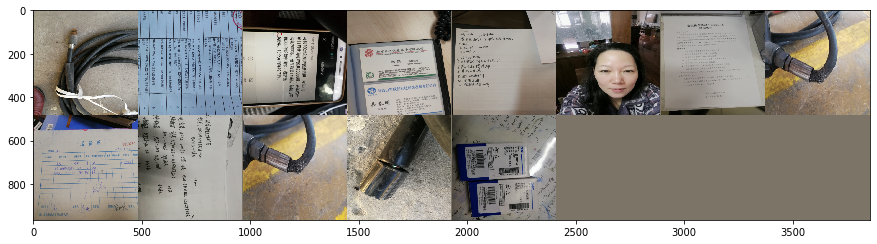

In [71]:
out = torchvision.utils.make_grid(img_tensor.cpu())
imshow(out)

In [73]:
classify_Image(classify_table)